### MGT-502 Final Project

__Nadège Baertschi & Zélia Décaillet__

_May 2025_

# ReadingBuddy - Book Recommender

## Import libraries

In [140]:
pip install sentence-transformers gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [141]:
pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [142]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Import Data

In [143]:
#Remove?
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

In [ ]:
repo_url = "https://raw.githubusercontent.com/baertsch/MGT-502-ML-Project/main/"

# Load datasets
interactions_train_df = pd.read_csv(repo_url + "kaggle_data/interactions_train.csv")
interactions_train_df.rename(columns={"u": "user_id"}, inplace=True)

#Original items.csv with a lot of missing data
#items_df = pd.read_csv(repo_url + "kaggle_data/items.csv")

#New items.csv with less missing data
items_df = pd.read_csv(repo_url + "kaggle_data/items_df.csv")
sample_submission_df = pd.read_csv(repo_url + "kaggle_data/sample_submission.csv")

#Display
display(interactions_train_df.head())
display(items_df.head())
display(sample_submission_df.head())



,user_id,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis
0,Classification décimale universelle : édition ...,['UDC Consortium (The Hague)'],9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,NaN
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,C'est dans l'interaction en classe que s'actua...
2,Histoire de vie et recherche biographique : pe...,"['Aneta Slowik', 'Hervé Breton', 'Gaston Pineau']",2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Depuis la parution en 1918 de l'ouvrage fondat...
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,NaN
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,"Trois histoires d'amour, un lanceur d'alerte, ..."


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [145]:
n_users = interactions_train_df['user_id'].nunique()
n_items = items_df['i'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of books in the library: {items_df['i'].nunique()}")

Number of users: 7838
Number of books in the library: 15291


It looks like there are __7838__ users and __15291__ books in the library.

## Split the data

In [146]:
#Split the dataset based on the timestamp
interactions_train_df.sort_values(by=['user_id', 't'], inplace=True)
interactions_train_df['pct_rank'] = interactions_train_df.groupby('user_id')['t'].rank(pct=True, method='dense')
interactions_train_df.reset_index(drop=True, inplace=True)
interactions_train_df.head(10)

,user_id,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [147]:
train_data = interactions_train_df[interactions_train_df['pct_rank'] <= 0.8]
test_data = interactions_train_df[interactions_train_df['pct_rank'] > 0.8]
print("Training set size:", train_data.shape[0])
print("Test set size:", test_data.shape[0])

Training set size: 66577
Test set size: 20470


In [148]:
print(train_data[['user_id','i']].duplicated().sum())
print(test_data[['user_id','i']].duplicated().sum())

16055
2044


It seems that the some users have interacted with some items more than once.

## First model: Item-to-Item

We are going to build first a model which treats doesn't account for the frequency a user has interacted with an item.

### Create User-Item Matrices

In [149]:
def create_data_matrix1(data, n_users, n_items):
    """
    This function creates a data matrix with binary values for the interactions, 1 is interaction and 0 is no interaction.
    The data matrix is of shape (n_users, n_items). 
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data['user_id'].values, data['i'].values] = 1
    return data_matrix

In [150]:
full_data_matrix = create_data_matrix1(interactions_train_df, n_users, n_items)

### Visualization of the matrices for a small portion of the data

In [151]:
def plot_interaction_heatmap1(data_matrix, n_users=50,n_items=50, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='YlGnBu', cbar=True,cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

In [152]:
train_data_matrix = create_data_matrix1(train_data, n_users, n_items)
test_data_matrix = create_data_matrix1(test_data, n_users, n_items)

### Item Similarity

In [153]:
item_similarity = cosine_similarity(full_data_matrix.T)
print(item_similarity)
print("Item similarity shape:", item_similarity.shape)

[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
Item similarity shape: (15291, 15291)


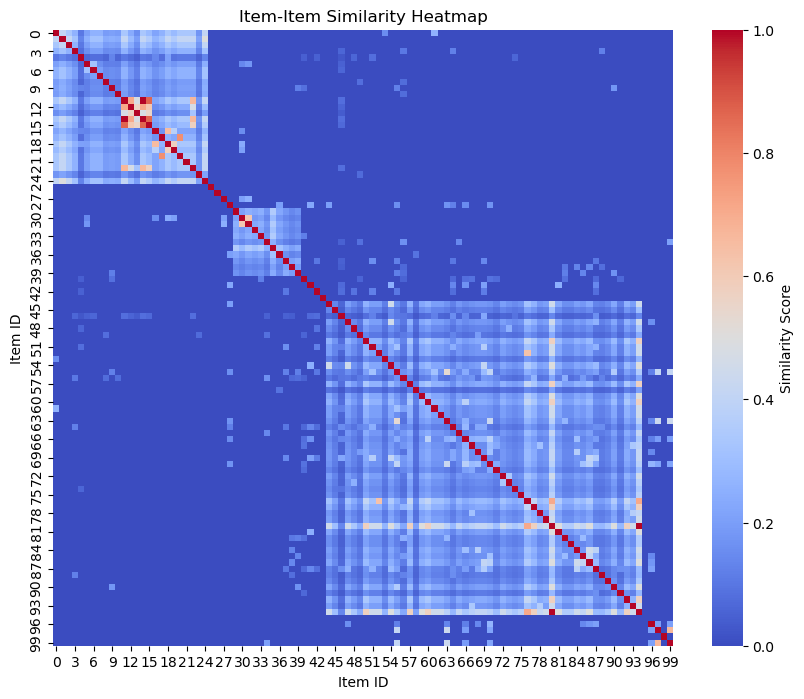

In [154]:
# Let's visualize the item similarity matrix
def plot_similarity_heatmap(matrix, n_items=50, title="Item Similarity Heatmap",x_label='X ID',y_label='y ID'):
    """
    This function plots a heatmap of the item similarity matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:n_items, :n_items], cmap='coolwarm', cbar=True,cbar_kws={'label': 'Similarity Score'})
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
plot_similarity_heatmap(item_similarity, n_items=100, title="Item-Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

Let's look at the clusters of high similarity 

In [155]:
items_df[(items_df['i']>=11) & (items_df['i']<=15)]

,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis
11,Rendre les élèves acteurs de leurs apprentissa...,"Béal, Yves",9782206013725; 220601372X,Delagrave,apprentissage (psychologie)--enfant; apprentis...,11,Présentation de réflexions et de remarques aut...
12,L'apprentissage par projets au secondaire : gu...,"Larmer, John",9782765033202; 276503320X,Chenelière éducation,apprentissage (psychologie)--enseignement seco...,12,NaN
13,Pour une pédagogie du projet /,"Bordalo, Isabelle",9782011709219; 2011709210,Hachette éducation,Enseignement--Méthode des projets,13,"La demande de projet est incontournable, dans ..."
14,Une classe qui coopère : pourquoi ? comment ? /,"Staquet, Christian",9782850084324; 2850084328,Chronique sociale,apprentissage (psychologie)--classe (enseignem...,14,Comment organiser les apprentissages pour que ...
15,Penser le projet : concepts et outils d'une pé...,"Tilman, Francis",2850085510; 9782850085512,Chronique sociale,pédagogie de la maîtrise,15,La pédagogie du projet est omniprésente dans l...


In [156]:
items_df[(items_df['i']>=0) & (items_df['i']<=19)][['Title','Subjects']]

,Title,Subjects
0,Classification décimale universelle : édition ...,Classification décimale universelle; Indexatio...
1,Les interactions dans l'enseignement des langu...,didactique--langue étrangère - enseignement; d...
2,Histoire de vie et recherche biographique : pe...,Histoires de vie en sociologie; Sciences socia...
3,Ce livre devrait me permettre de résoudre le c...,Moyen-Orient; Bandes dessinées autobiographiqu...
4,Les années glorieuses : roman /,France--1945-1975; Roman historique; Roman fra...
5,100 idées pour mieux gérer les troubles de l'a...,Trouble déficitaire de l'attention avec ou san...
6,La boîte à outils des formateurs : 71 outils...,Formateurs (éducation des adultes)--Formation...
7,L'autorité éducative dans la classe : douze si...,autorité--relation maître-élève; autorité--ens...
8,Un autre regard sur le climat /,Climat--Détérioration; Bandes dessinées
9,Le mirage de la croissance verte /,Développement économique--Aspect environnement...


In [157]:
# Find item pairs with similarity between 0.8 and 1
similar_items = []
threshold_min = 0.8
threshold_max = 1.0

for i in range(item_similarity.shape[0]):
    for j in range(i + 1, item_similarity.shape[1]):  # Avoid duplicate pairs and self-similarity
        if threshold_min <= item_similarity[i, j] <= threshold_max:
            similar_items.append((i, j, item_similarity[i, j]))

# Display the results
print("Item pairs with similarity between 0.8 and 1:")
for item1, item2, similarity in similar_items:
    print(f"Item {item1} and Item {item2} have similarity: {similarity}")

Item pairs with similarity between 0.8 and 1:
Item 11 and Item 15 have similarity: 0.8660254037844388
Item 14 and Item 15 have similarity: 0.8660254037844388
Item 79 and Item 7129 have similarity: 0.8944271909999159
Item 80 and Item 94 have similarity: 1.0
Item 151 and Item 11561 have similarity: 0.8660254037844388
Item 153 and Item 156 have similarity: 0.801783725737273
Item 161 and Item 166 have similarity: 0.8164965809277261
Item 299 and Item 1492 have similarity: 1.0
Item 303 and Item 307 have similarity: 1.0
Item 303 and Item 313 have similarity: 1.0
Item 303 and Item 321 have similarity: 1.0
Item 303 and Item 327 have similarity: 1.0
Item 307 and Item 313 have similarity: 1.0
Item 307 and Item 321 have similarity: 1.0
Item 307 and Item 327 have similarity: 1.0
Item 313 and Item 321 have similarity: 1.0
Item 313 and Item 327 have similarity: 1.0
Item 314 and Item 9934 have similarity: 0.8944271909999159
Item 321 and Item 327 have similarity: 1.0
Item 530 and Item 532 have similari

In [158]:
display(items_df[(items_df['i']==76)])
display(items_df[(items_df['i']==80)]) 

,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis
76,Silver spoon = La cuillère d'argent /,"Arakawa, Hiromu, 1973-",9782351428344; 235142834X; 9782351428351; 2351...,Kurokawa,Bandes dessinées; Mangas,76,Yûgo Hachiken est un collégien qui vient du pr...


,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis
80,Erased /,"Sanbe, Kei",9782355926990; 2355926999; 9782355927140; 2355...,Ki-oon,Mangas; Bandes dessinées,80,2006. Aspirant mangaka dont la carrière peine ...


### Prediction using User Similarity

In [159]:
def item_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on item similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The item-item similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T

In [160]:
item_based_predictions = item_based_predict(full_data_matrix, item_similarity)
print("Predicted Interaction Matrix using Item-to-Item Similarity")
print(item_based_predictions)
print("Predicted Interaction Matrix shape:", item_based_predictions.shape)

Predicted Interaction Matrix using Item-to-Item Similarity
[[0.50330859 0.887555   0.72071387 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.02788041 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


## Model: User-to-User Collaborative Filtering with Implicit Feedback

### User Similarity Matrix

In [161]:
user_similarity = cosine_similarity(full_data_matrix)
print(user_similarity)
print("User similarity shape:", user_similarity.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.08084521]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.08084521 ... 0.         0.         1.        ]]
User similarity shape: (7838, 7838)


### Prediction using User Similarity

\begin{equation}
{p}_{u}(i) = \frac{\sum\limits_{u' \in U} \text{sim}(u, u') \cdot {R}_{u'}(i)}{\sum\limits_{u' \in U} \text{sim}(u, u')}
\end{equation}


Explanation:
*   $P_u(i)$ is the likelihood of user $u$ interacting with item $i$. This is the value we want to compute.
*   $\text{sim}(u, u')$ is the cosine similarity between users $u$ and $u'$.
*   $R_u'(i)$ is one if user $u'$ has already interacted with item $i$. Otherwise it is zero.
*   $U$ is the set of all users in the dataset.

This formula calculates the likelihood of interaction between user $ u $ and item $ i $ based on interactions of similar users with that item. The weighted sum of interactions from similar users is normalized by the sum of the similarities.

In [162]:
def user_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on user similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The user-user similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred


In [163]:
user_based_predictions = user_based_predict(full_data_matrix, user_similarity)
print("Predicted Interaction Matrix using User-to-User Similarity")


Predicted Interaction Matrix using User-to-User Similarity


## Evaluation of the two recommender models

In [164]:
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k,map_at_k = 0, 0, 0

    for user in range(num_users):
        # Step 1: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]  # Complete this line to retrieve top-K item indices for the user
        
        # Step 2: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.sum([ground_truth[user,i] for i in top_k_items]) 
        
        # Step 3: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()  

        # Update Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

        avg_precision_at_k = 0
        for i in range(k):
            if ground_truth[user, top_k_items[i]] == 1:
                avg_precision_at_k += np.sum(ground_truth[user, top_k_items[:i+1]]) / (i + 1)
        map_at_k += avg_precision_at_k / min(total_relevant_items, k) 

    # Step 4: Calculate the average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users
    map_at_k /= num_users
    
    return precision_at_k, recall_at_k, map_at_k

In [165]:
precision_item_k, recall_item_k, map_item_k= precision_recall_at_k(item_based_predictions, test_data_matrix, k=10)
precision_user_k, recall_user_k, map_user_k = precision_recall_at_k(user_based_predictions, test_data_matrix, k=10)


print(f'Item-based CF Precision@K {precision_item_k}, Recall@K {recall_item_k}, MAP@K {map_item_k} for k=10')
print(f'User-based CF Precision@K {precision_user_k}, Recall@K {recall_user_k}, MAP@K {map_user_k} for k=10')

Item-based CF Precision@K 0.15147996937994507, Recall@K 0.807978450064057, MAP@K 0.17368659391638339 for k=10
User-based CF Precision@K 0.160053585098238, Recall@K 0.8852508120671551, MAP@K 0.17607291359078095 for k=10


## Recommendations dataframe using the best model -> User-based model

In [166]:
def create_recommendations_csv(predictions_matrix, name='recommendations.csv'):
    user_based_recommendations = []
    for user_id in range(predictions_matrix.shape[0]):
        # Indices of the top 10 items for each user (based on predicted interactions)
        top_10_items = np.argsort(predictions_matrix[user_id])[-10:][::-1]  # Sorting them in descending order
        
        top_10_items_str = " ".join(map(str, top_10_items))
        
        # Append the user_id and the recommendations as a string
        user_based_recommendations.append([user_id, top_10_items_str])

    recommendations_df = pd.DataFrame(user_based_recommendations, columns=['user_id', 'recommendation'])
    recommendations_df.to_csv(name, index=False)
    print("Recommendations CSV created successfully.")
    return recommendations_df

In [167]:
recommendations_df = create_recommendations_csv(user_based_predictions, name='user_based_recommendations.csv')
recommendations_df.head()

Recommendations CSV created successfully.


,user_id,recommendation
0,0,13 4 12 23 15 11 14 8 5 9
1,1,38 39 30 31 34 36 37 32 33 29
2,2,46 58 49 56 53 91 64 87 45 71
3,3,149 169 163 167 128 133 143 40 139 165
4,4,203 198 207 205 195 202 193 191 199 201


## Inclusion of frequency

This one accounts the number of times the user has interacted with the item. So in the formula:

\begin{equation}
{p}_{u}(i) =  \frac{\sum\limits_{i' \in I} \text{sim}(i, i') \cdot {R}_{u}(i')}{\sum\limits_{i' \in I} \text{sim}(i, i')}
\end{equation}

$R_u(i')$ is the number of times user u interacted with item i'

In [168]:
def create_data_matrix2(data, n_users, n_items):
    """
    This function creates a data matrix with frequency values for the interactions. 
    The matrix is of shape (n_users, n_items) where each value represents the frequency of interaction.
    """
    # Initialize a matrix of zeros, where rows represent users and columns represent items
    data_matrix = np.zeros((n_users, n_items))
    
    # Add the frequency of interactions between users and items
    for _, row in data.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['i'])
        data_matrix[user_id, item_id] += 1  # Increment the count for each interaction
    
    return data_matrix

In [169]:
train_data_matrix2 = create_data_matrix2(train_data, n_users, n_items)
# Display the matrices
print("Training data matrix")
print(train_data_matrix2)
print("Number of interactions: ", np.sum(train_data_matrix2))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  66577.0


In [170]:
full_data_matrix2 = create_data_matrix2(interactions_train_df, n_users, n_items)

### Let's try an user-to-user collaborative filtering with implicit feedback with these matrices

In [171]:
user_similarity2 = cosine_similarity(full_data_matrix2)
print(user_similarity2)
print("User similarity shape:", user_similarity2.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.02539184]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.02539184 ... 0.         0.         1.        ]]
User similarity shape: (7838, 7838)


In [172]:
user_based_predictions2 = user_based_predict(full_data_matrix2, user_similarity2)
print("Predicted Interaction Matrix using User-to-User Similarity considering frequency")
print(user_based_predictions2)
print("Predicted Interaction Matrix shape:", user_based_predictions2.shape)

Predicted Interaction Matrix using User-to-User Similarity considering frequency
[[0.13107405 0.16303224 0.12982504 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01243528 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


### Let's evaluate the model with these matrices

In [173]:
precision_user_k2, recall_user_k2,map_user_k2 = precision_recall_at_k(user_based_predictions2, test_data_matrix, k=10)
print(f'User-based CF Precision@K {precision_user_k2}, Recall@K {recall_user_k2}, MAP@K {map_user_k2} for k=10')

User-based CF Precision@K 0.16210768053074526, Recall@K 0.8745431828569113, MAP@K 0.171519605630796 for k=10


### Dataframe with improved recommendations

In [174]:
recommendations_df2 = create_recommendations_csv(user_based_predictions2, name='user_based_recommendations2.csv')
recommendations_df2.head()

Recommendations CSV created successfully.


,user_id,recommendation
0,0,3 4 13 15 12 14 23 11 8 5
1,1,37 36 38 39 30 31 34 1806 29 32
2,2,53 58 3055 14578 92 81 15228 91 8999 13912
3,3,132 10475 118 161 117 149 146 169 163 10476
4,4,195 203 202 198 207 205 193 199 191 201


### Recommendations for a specific user

In [175]:
import random
# Pick a user at random
user_id = random.choice(range(user_based_predictions2.shape[0]))
print("Selected User ID:", user_id)

# Get top-10 recommendations for the selected user
top_10 = np.argsort(user_based_predictions2[user_id, :])[-10:][::-1]

display(top_10)

Selected User ID: 2979


array([ 4309,  5601, 10105,  7254,  2418, 12554,  6770,  7543,  7018,
        6774])

In [176]:
top_10_df = pd.DataFrame({'i':top_10})

In [177]:
df = top_10_df.merge(items_df[['i', 'Title', 'ISBN Valid']], left_on='i', right_on='i')
display(df)

,i,Title,ISBN Valid
0,4309,Des valeurs : une approche sociologique /,9782070146406; 2070146405
1,5601,L'oeuvre d'art à l'époque de sa reproductibili...,9782844854438; 2844854435; 9782844855893; 2844...
2,10105,L'image partagée : la photographie numérique /,9782845975309; 2845975309
3,7254,L'art numérique /,2878112342; 9782878112344
4,2418,Le paradigme de l'art contemporain : structure...,9782070139231; 2070139239
5,12554,Les NFT en 40 questions : comprendre les Non F...,9782100833047; 2100833049
6,6770,La guerre des écrivains : 1940-1953 /,2213602115; 9782213602110
7,7543,La disgrâce des statues : essai sur les confl...,2228931624; 9782228931625
8,7018,La sociologie à l'épreuve de l'art /,2916063145; 9782916063140; 9782916063225; 2916...
9,6774,De l'artification : enquêtes sur le passage à ...,9782713223365; 2713223369


## Improving similarity with book information

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer

items_df['content'] = items_df['Title'].fillna('') + ' ' + items_df['Subjects'].fillna('') + ' ' + items_df['Author'].fillna('') + ' ' + items_df['Publisher'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf.fit_transform(items_df['content'])

print(tfidf_matrix.shape)

(15291, 37776)


In [179]:
content_similarity = cosine_similarity(tfidf_matrix)
print(content_similarity)
print(content_similarity.shape)

[[1.         0.         0.         ... 0.         0.         0.00372049]
 [0.         1.         0.01351119 ... 0.         0.         0.0126978 ]
 [0.         0.01351119 1.         ... 0.         0.         0.02913223]
 ...
 [0.         0.         0.         ... 1.         0.03262742 0.        ]
 [0.         0.         0.         ... 0.03262742 1.         0.        ]
 [0.00372049 0.0126978  0.02913223 ... 0.         0.         1.        ]]
(15291, 15291)


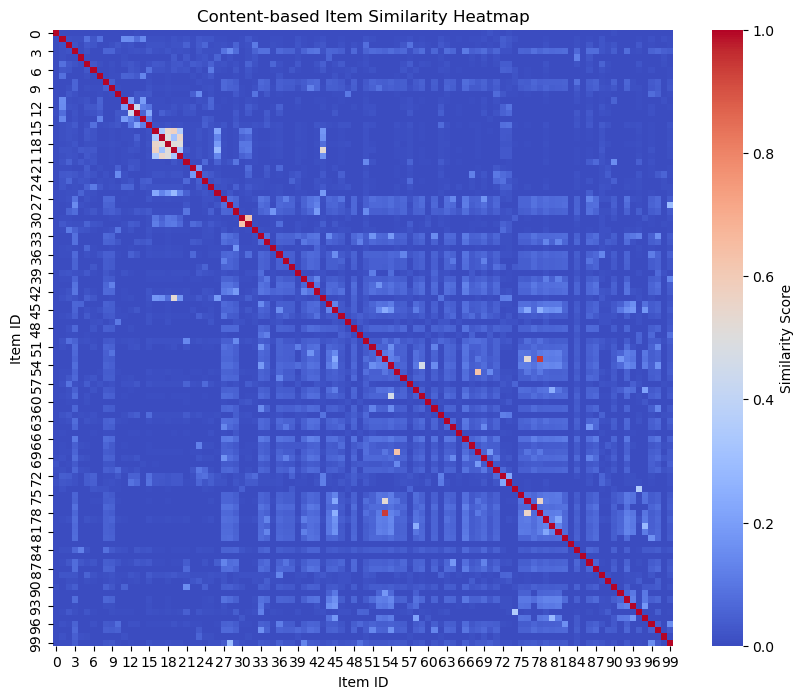

In [180]:
plot_similarity_heatmap(content_similarity, n_items=100, title="Content-based Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

In [181]:
items_df[(items_df['i']==53) | (items_df['i']==78)]

,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis,content
53,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351420171; 2351420179; 9782351420188; 2351...,Kurokawa,Shônen; Mangas; Bandes dessinées,53,"En voulant ressusciter leur mère, Edward et Al...",Fullmetal alchemist / Shônen; Mangas; Bandes d...
78,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351427552; 2351427556; 9782351427521; 2351...,Kurokawa,Bandes dessinées; Mangas,78,NaN,Fullmetal alchemist / Bandes dessinées; Mangas...


In [182]:
content_similarity[53, 78]

0.9412614372994692

In [183]:
content_based_predictions = item_based_predict(full_data_matrix, content_similarity)
print("Predicted Interaction Matrix using Content-based Similarity")
print(content_based_predictions)

Predicted Interaction Matrix using Content-based Similarity
[[2.89769405e-02 8.64004987e-03 5.89406264e-03 ... 0.00000000e+00
  1.86472480e-03 2.03498134e-03]
 [0.00000000e+00 3.21841940e-04 9.16090877e-04 ... 0.00000000e+00
  3.89858416e-03 4.10244923e-04]
 [1.77496869e-03 1.20322142e-03 2.16864097e-03 ... 3.94418688e-02
  4.00923726e-02 1.99135114e-03]
 ...
 [0.00000000e+00 6.86531038e-05 5.15929327e-05 ... 1.62794679e-03
  1.34069576e-03 4.87003339e-05]
 [0.00000000e+00 4.52582072e-05 7.40193842e-05 ... 1.72467791e-03
  1.29553050e-03 6.98694286e-05]
 [0.00000000e+00 1.86972707e-04 1.54509429e-04 ... 0.00000000e+00
  7.22346422e-04 2.98465428e-04]]


In [184]:
precision_content_k, recall_content_k, map_content_k = precision_recall_at_k(content_based_predictions, test_data_matrix, k=10)
print(f'Content-based CF Precision@K for k=10: {precision_content_k} Recall@K: {recall_content_k} MAP@K: {map_content_k}')   

Content-based CF Precision@K for k=10: 0.10056136769585121 Recall@K: 0.6209011654727683 MAP@K: 0.14396374635306652


In [185]:
content_based_predictions_df = create_recommendations_csv(content_based_predictions, name='content_based_recommendations.csv')

Recommendations CSV created successfully.


In [ ]:
def save_item_to_item_recommendations(similarity_matrix, filename='item_to_item_recommendations.csv', top_n=10):
    recommendations = []
    n_items = similarity_matrix.shape[0]
    for item_id in range(n_items):
        # Exclude self-similarity by setting it to -inf
        sim_scores = similarity_matrix[item_id].copy()
        sim_scores[item_id] = -np.inf
        # Get indices of top-N similar items
        top_items = np.argsort(sim_scores)[-top_n:][::-1]
        top_items_str = " ".join(map(str, top_items))
        recommendations.append([item_id, top_items_str])
    df = pd.DataFrame(recommendations, columns=['item_id', 'recommendation'])
    df.to_csv(filename, index=False)
    print(f"Saved item-to-item recommendations to {filename}")

In [ ]:
save_item_to_item_recommendations(item_similarity, filename='item_to_item_recommendations.csv', top_n=10)

## Hybrid: item & user similarities combined

### Hybrid recommendation with user & content

#### Graph to find the best weight

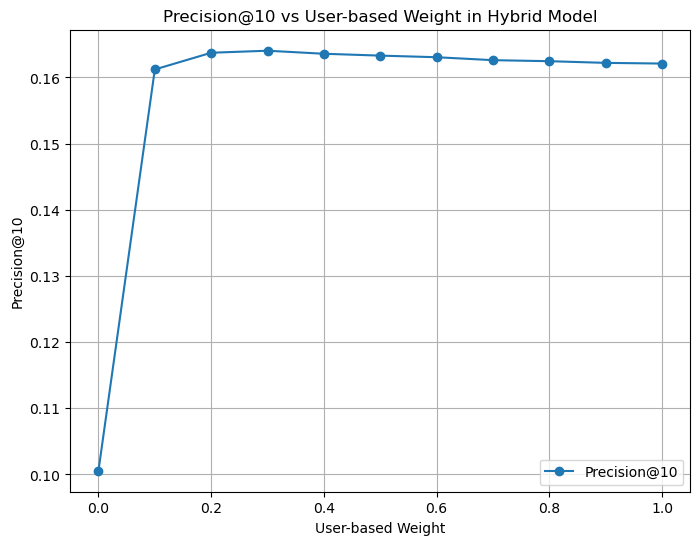

Best Precision@10: 0.1640 at user-based weight: 0.30


In [ ]:
'''
weights = np.arange(0, 1.05, 0.1)  # from 0 to 1, step 0.1
precisions = []

for w in weights:
    hybrid_pred = user_based_predictions2 * w + content_based_predictions * (1 - w)
    precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(weights, precisions, marker='o', label='Precision@10')
plt.xlabel('User-based Weight')
plt.ylabel('Precision@10')
plt.title('Precision@10 vs User-based Weight in Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(precisions)
print(f'Best Precision@10: {precisions[best_idx]:.4f} at user-based weight: {weights[best_idx]:.2f}')
'''

#### Hybrid model

In [189]:
hybrid_predictions1 = user_based_predictions2*0.3 + content_based_predictions*0.8
print(precision_recall_at_k(hybrid_predictions1, test_data_matrix, k=10))

(0.16399591732584576, 0.8832213939480045, 0.17600995251473014)


In [80]:
hybrid_recommendations_df1 = create_recommendations_csv(hybrid_predictions1, name='hybrid_recommendation1.csv')

Recommendations CSV created successfully.


### Hybrid recommendations with user & item

#### Graph to find the best weight

In [ ]:

weights = np.arange(0, 1.05, 0.1)  # from 0 to 1, step 0.1
precisions = []

for w in weights:
    hybrid_pred = user_based_predictions2 * w + item_based_predictions * (1 - w)
    precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(weights, precisions, marker='o', label='Precision@10')
plt.xlabel('User-based Weight')
plt.ylabel('Precision@10')
plt.title('Precision@10 vs User-based Weight in Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(precisions)
print(f'Best Precision@10: {precisions[best_idx]:.4f} at user-based weight: {weights[best_idx]:.2f}')

#### Hybrid model

In [82]:
hybrid_predictions2 = user_based_predictions*0.4 + item_based_predictions*0.6 
print(precision_recall_at_k(hybrid_predictions2, test_data_matrix, k=10))

(0.16991579484561956, 0.9109070248623674, 0.18156247534878042)


In [83]:
hybrid_recommendations_df2 = create_recommendations_csv(hybrid_predictions2, name='hybrid_recommendation2.csv')

Recommendations CSV created successfully.


### Hybrid recommendation with user, item & content

#### Graph to find best weight

In [ ]:

weight_range = np.arange(0, 1.01, 0.1)
precisions = []
weights_list = []

for w1 in weight_range:
    for w2 in weight_range:
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue
        hybrid_pred = user_based_predictions2 * w1 + item_based_predictions * w2 + content_based_predictions * w3
        precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
        precisions.append(precision)
        weights_list.append((w1, w2, w3))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(precisions)), precisions, marker='o')
plt.xlabel('Weight Combination Index')
plt.ylabel('Precision@10')
plt.title('Precision@10 for Different Hybrid Weights')
plt.grid(True)
plt.show()

# Print the best weights
best_idx = np.argmax(precisions)
best_weights = weights_list[best_idx]
print(f'Best Precision@10: {precisions[best_idx]:.4f} at weights user={best_weights[0]:.2f}, item={best_weights[1]:.2f}, content={best_weights[2]:.2f}')


#### Hybrid Model

In [85]:
hybrid_predictions3 = user_based_predictions2*0.2 + item_based_predictions*0.2 + content_based_predictions*0.6
print(precision_recall_at_k(hybrid_predictions3, test_data_matrix, k=10))

(0.17080887981627446, 0.9094717248719759, 0.18023066807193977)


In [86]:
hybrid_recommendations_df3 = create_recommendations_csv(hybrid_predictions3, name='hybrid_recommendation3.csv')

Recommendations CSV created successfully.


## Text embeddings

In [87]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import InputExample, SentenceTransformer, losses, models
from torch.utils.data import DataLoader


/Users/zeliadecaillet/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
sentence_model = SentenceTransformer("all-mpnet-base-v2")
#sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# train_examples = []

# # Group interactions by user
# user_groups = train_data.groupby('user_id')['i'].apply(list)

# for user_items in user_groups:
#     # Positive pairs: all pairs of items the user interacted with
#     for i in range(len(user_items)):
#         for j in range(i + 1, len(user_items)):
#             item1 = items_df.loc[items_df['i'] == user_items[i], 'content'].values[0]
#             item2 = items_df.loc[items_df['i'] == user_items[j], 'content'].values[0]
#             train_examples.append(InputExample(texts=[item1, item2]))

# train_subset = random.sample(train_examples, k=30000)
# train_dataloader = DataLoader(train_subset, shuffle=True, batch_size=16)
# train_loss = losses.MultipleNegativesRankingLoss(sentence_model)

# sentence_model.fit(
#     train_objectives=[(train_dataloader, train_loss)],
#     epochs=1,
#     warmup_steps=100,
#     show_progress_bar=True
# )

# Generate embeddings for all items
items_df['embedding'] = list(sentence_model.encode(items_df['content'].tolist(), show_progress_bar=True))


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

In [89]:
embeddings_matrix = np.vstack(items_df['embedding'].values)
item_embedding_similarity = cosine_similarity(embeddings_matrix, embeddings_matrix)
print(item_embedding_similarity)

[[1.         0.15151511 0.1307109  ... 0.11432153 0.16508037 0.17863786]
 [0.15151511 1.0000001  0.38859704 ... 0.1582081  0.06512423 0.3302444 ]
 [0.1307109  0.38859704 0.99999976 ... 0.14526115 0.18115    0.16155526]
 ...
 [0.11432153 0.1582081  0.14526115 ... 0.9999999  0.43324894 0.14977127]
 [0.16508037 0.06512423 0.18115    ... 0.43324894 1.0000001  0.00547265]
 [0.17863786 0.3302444  0.16155526 ... 0.14977127 0.00547265 1.0000001 ]]


In [90]:
embedding_based_predictions = item_based_predict(full_data_matrix, item_embedding_similarity)

In [91]:
precision, recall, map_k = precision_recall_at_k(embedding_based_predictions, test_data_matrix, k=10)
print(f"Embedding-based Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, MAP@10: {map_k:.4f}")

Embedding-based Precision@10: 0.0410, Recall@10: 0.2933, MAP@10: 0.0682


### Graph to find the best weights

In [92]:
'''
weight_range = np.arange(0, 1.05, 0.1)
best_precision = 0
best_weights = (0, 0, 0, 0)
precisions = []
weights_list = []

for w1 in weight_range:
    for w2 in weight_range:
        for w3 in weight_range:
            w4 = 1.0 - w1 - w2 - w3
            if w4 < 0 or w4 > 1:
                continue
            # Hybrid prediction: user, item, content, embedding
            hybrid_pred = (
                user_based_predictions2 * w1 +
                item_based_predictions * w2 +
                content_based_predictions * w3 +
                embedding_based_predictions * w4
            )
            precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
            precisions.append(precision)
            weights_list.append((w1, w2, w3, w4))
            if precision > best_precision:
                best_precision = precision
                best_weights = (w1, w2, w3, w4)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(precisions)), precisions, marker='o')
plt.xlabel('Weight Combination Index')
plt.ylabel('Precision@10')
plt.title('Precision@10 for Different Hybrid Weights (User, Item, Content, Embedding)')
plt.grid(True)
plt.show()

print(f'Best Precision@10: {best_precision:.4f} at weights user={best_weights[0]:.2f}, item={best_weights[1]:.2f}, content={best_weights[2]:.2f}, embedding={best_weights[3]:.2f}')
'''

"\nweight_range = np.arange(0, 1.05, 0.1)\nbest_precision = 0\nbest_weights = (0, 0, 0, 0)\nprecisions = []\nweights_list = []\n\nfor w1 in weight_range:\n    for w2 in weight_range:\n        for w3 in weight_range:\n            w4 = 1.0 - w1 - w2 - w3\n            if w4 < 0 or w4 > 1:\n                continue\n            # Hybrid prediction: user, item, content, embedding\n            hybrid_pred = (\n                user_based_predictions2 * w1 +\n                item_based_predictions * w2 +\n                content_based_predictions * w3 +\n                embedding_based_predictions * w4\n            )\n            precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)\n            precisions.append(precision)\n            weights_list.append((w1, w2, w3, w4))\n            if precision > best_precision:\n                best_precision = precision\n                best_weights = (w1, w2, w3, w4)\n\n# Plot\nplt.figure(figsize=(12, 6))\nplt.plot(range(len(prec

### Hybrid recommendation with embedding

In [93]:
hybrid_predictions4 = user_based_predictions2*0.1 + item_based_predictions * 0.2 + content_based_predictions * 0.4 + embedding_based_predictions*0.3
print(precision_recall_at_k(hybrid_predictions4, test_data_matrix, k=10))

(0.17089818831333975, 0.9101317588599334, 0.18040529038488154)


In [94]:
hybrid_recommendations_df4 = create_recommendations_csv(hybrid_predictions4, name='hybrid_recommendation4.csv')

Recommendations CSV created successfully.
